In [66]:
import os
import pandas as pd
import numpy as np
import pandas_datareader as pdr
# cvxpy >= 1.0, use pip instead of conda to install. 
import cvxpy as cvx

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

https://www.top1000funds.com/wp-content/uploads/2011/06/Eigenfactor_Adjusted_Covariance_Matrices_May2011.pdf

In [199]:
#Only 19 ticker in MMI constitutes after merge of DOW-DuPont
list_MMI = ['DWDP', 'CVX', 'WFC', 'MRK', 'XOM', 'DIS', 'JPM', 'KO', 'PG', 'JNJ', 'HPQ', 'MSFT', 
               'AXP', 'IBM', 'WMT', 'BA', 'MMM', 'MCD', 'GE']
N = len(list_MMI) #19
date0 = '2015-01-01'
date1 = '2019-01-01'

In [200]:
#load data or use cached data when force_refresh is false. 
force_refresh= False
file_ret = 'MMI_DailyReturns.csv'
file_mktcap = 'MMI_MktCap.csv'
if force_refresh:
    df_data = pdr.get_data_yahoo(list_MMI, date0, date1)
    df_price = df_data['Adj Close']
    df_ret = np.log(df_price).diff().dropna(how='all')
    df_ret.to_csv(file_ret, index=True)
    #use illustrative MktCap data. 
    ie_mktcap = [i+1 for i in xrange(13)]+[1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
    df_mktcap = pd.DataFrame(index=df_ret.index, columns=df_ret.columns)
    df_mktcap.iloc[0]=ie_mktcap
    df_mktcap = df_mktcap.fillna(method='ffill')
    df_mktcap.to_csv(file_mktcap, index=True)
else:
    df_ret = pd.read_csv(os.path.join('data',file_ret), index_col=0, parse_dates=True)
    df_mktcap = pd.read_csv(os.path.join('data',file_mktcap), index_col=0, parse_dates=True)
print('DateRange {t0} to {t1}'.format(t0=df_ret.index.min().date(), t1=df_ret.index.max().date()))
idx_MMI = df_ret.columns

DateRange 2015-01-05 to 2018-12-31


In [201]:
#alway use excess return, assuming fixed risk free rate for simplicity
srs_rf = pd.Series(0.01/252, index=df_ret.index) #daily risk free rate
df_ret_e = df_ret.apply(lambda x: x - srs_rf)
df_ret_m = df_ret_e.resample('BM').sum()
# calc covariance matrix, using monthly return 
df_cov = df_ret_m.cov()
df_mkt_w = (df_mktcap.T/df_mktcap.T.sum()).T
df_mkt = (df_mkt_w*df_ret).dropna(how='all').sum(axis=1).to_frame(name='MKT')
#df_ret_fullmkt = pd.concat([df_mkt, df_ret], axis=1)

V = df_cov.values
V_inv = np.linalg.inv(V)
beta = (df_ret_fullmkt.cov() / df_mkt.var())['MKT'][1:]
e = np.ones(N)

#f = df_ret_m.mean()
np.random.seed = 123
#use randomg alphas
alpha = pd.Series(np.random.standard_normal(N), index=list_MMI)
f_MKT = 0.01
mu = beta*f_MKT
f = mu + alpha

In [202]:
df_f = pd.concat([df_mkt, df_ret.sub(df_mkt['MKT'], axis=0)], axis=1)
df_mkt_wf= df_mkt_w
df_mkt_wf['MKT'] = 1.0

In [203]:
W=200
T, N = df_f.shape
idx_t = df_f.index.tolist()
dict_cov = {}
dict_vol = {}
for i in xrange(T-W):
    t = idx_t[i]
    df_f_t = df_f.iloc[i: i+W]
    cov_t = df_f_t.cov()
    dict_cov[t] = cov_t
    h = df_mkt_wf.loc[t]
    dict_vol[t] = h.T.dot(cov_t).dot(h)**0.5
df_cov = pd.Series(dict_cov)
df_vol = pd.Series(dict_vol)

-------------
#### Bias for single stocks

In [204]:
df_r = df_ret
T, N = df_r.shape
idx_t = df_r.index.tolist()
list_b = []
for i in xrange(W, T-W):
    df_ret_t = df_r.iloc[i: i+W]
    df_std_t = df_r.std()
    b = df_r.iloc[i]/df_std_t
    b.name = idx_t[i]
    list_b.append(b)
df_b_stock = pd.concat(list_b, axis=1).T

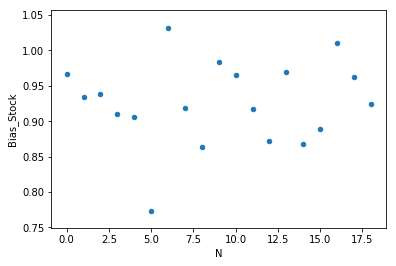

In [205]:
df_B_stock = df_b_stock.std()
df_B_plot = df_B_stock.to_frame(name='Bias_Stock')
df_B_plot['N'] = xrange(N)
df_B_plot.plot.scatter(x='N', y='Bias_Stock')

------------
#### Bias for Portfolio Simulation

In [207]:
df_f = df_excess_ret
M = 100
W = 200
T, N = df_f.shape

In [222]:
df_M = pd.DataFrame(np.random.standard_normal(M*N).reshape(M,N), 
                    columns=df_f.columns, index=xrange(M))
df_M['MKT'] = 0
list_P_M = []
for m in xrange(M):
    srs_m = df_M.loc[m]
    df_R_m = srs_m * df_f
    #df_R_m['MKT'] = df_f['MKT']
    df_p_m = (df_R_m * df_mkt_wf).sum(axis=1)
    df_p_m.name = m
    list_P_M.append(df_p_m)
df_P_M = pd.concat(list_P_M, axis=1)
df_P_M = df_P_M.add(df_mkt['MKT'], axis=0)
df_b_pf = df_P_M.div(df_vol,axis=0)

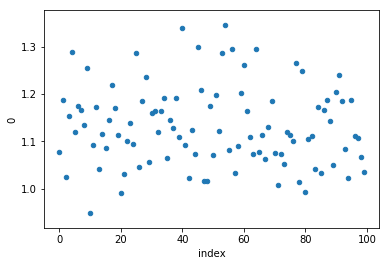

In [223]:
df_b_pf.std().to_frame().reset_index().plot.scatter(x='index', y=0)

In [221]:
df_P_M.add(df_mkt['MKT'], axis=0)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.012813,-0.016562,-0.014611,-0.016578,-0.016317,-0.017247,-0.013131,-0.018805,-0.017704,-0.017747,...,-0.015258,-0.016698,-0.019994,-0.015161,-0.014520,-0.016954,-0.017852,-0.019475,-0.017702,-0.015890
2015-01-06,-0.003428,-0.010713,-0.008733,-0.006833,-0.011505,-0.014531,-0.010965,-0.011421,-0.008300,-0.008170,...,-0.007315,-0.010937,-0.012686,-0.005592,-0.006860,-0.007728,-0.013570,-0.010195,-0.008588,-0.008694
2015-01-07,0.013975,0.008176,0.006521,0.012044,0.004138,0.001956,0.007155,0.005875,0.009825,0.009682,...,0.010248,0.007679,0.009671,0.010775,0.006605,0.009020,0.007183,0.008286,0.011254,0.004901
2015-01-08,0.013446,0.015321,0.017831,0.013752,0.019592,0.020383,0.014455,0.019176,0.015498,0.018508,...,0.017345,0.017452,0.016591,0.015159,0.019950,0.016133,0.017474,0.016505,0.015622,0.020561
2015-01-09,-0.010539,-0.007877,-0.006066,-0.009341,-0.005853,-0.007330,-0.007018,-0.007972,-0.010546,-0.009302,...,-0.007898,-0.010216,-0.010389,-0.008479,-0.006273,-0.010134,-0.011632,-0.011138,-0.010126,-0.005024
2015-01-12,-0.008763,-0.006606,-0.010432,-0.005821,-0.012045,-0.010902,-0.008831,-0.010065,-0.006016,-0.006100,...,-0.008073,-0.008511,-0.006352,-0.006973,-0.010996,-0.009298,-0.006520,-0.007764,-0.008214,-0.009259
2015-01-13,-0.002316,0.000020,-0.002000,-0.001342,-0.000503,-0.000674,0.000121,-0.002657,-0.000771,-0.002285,...,-0.000979,-0.001076,-0.001413,-0.001846,-0.002235,-0.001446,-0.000373,-0.002219,-0.000635,-0.001134
2015-01-14,-0.010306,-0.008954,-0.009950,-0.010921,-0.009519,-0.008781,-0.008787,-0.008955,-0.011385,-0.007004,...,-0.009760,-0.010596,-0.015999,-0.009341,-0.002040,-0.012667,-0.011658,-0.015357,-0.013878,-0.004666
2015-01-15,-0.013483,-0.005734,-0.009851,-0.009078,-0.015362,-0.011657,-0.011571,-0.013037,-0.009387,-0.005615,...,-0.011062,-0.012344,-0.014984,-0.008848,-0.007341,-0.012171,-0.011149,-0.015272,-0.017712,-0.004556
